In [111]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nltk
from datasets import load_dataset

In [112]:
# Hyperparameters
block_size = 64
buffer_size = 10000 # maximum amount to be held in the memory buffer

## Get our Dataset ##

In [60]:
text = nltk.corpus.gutenberg.raw('melville-moby_dick.txt')
print(text[1:100])

Moby Dick by Herman Melville 1851]


ETYMOLOGY.

(Supplied by a Late Consumptive Usher to a Gr


## Encode the Text ##
Now we vectorize the text by encoding the strings with a numerical representation. Each character will be mapped to a value using a function. A decoder function will also map the values back to the same characters.

In [65]:
chars = sorted(set(text))
vocab_size = len(chars)

# Create a dict which maps each unique character to an index (Encoder)
string_to_int = {ch:i for i,ch in enumerate(chars)}
encode = lambda s: [string_to_int[c] for c in s]

# Create a dict which maps each unique index to a character (Decoder)
int_to_string = {i:ch for i,ch in enumerate(chars)}
decode = lambda l: ''.join([int_to_string[i] for i in l])

### StringLookup Layer in Tensorflow ###
Alternatively, this can be done with a StringLookup Layer in Tensorflow, which converts each character to a value based on a vocabulary. An inverted StringLookup Layer with the argument `invert=True` will convert a list of values back to the corresponding characters.

In [72]:
# StringLookup Layer
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=chars, mask_token=None)
chars_from_ids = tf.keras.layers.StringLookup(vocabulary=chars, mask_token=None, invert=True)
ids = ids_from_chars(chars)
print(ids)
invert = chars_from_ids(ids)
print(invert)

# Function to join the characters in the Tensor back into a String 
# (they will not be in the order of the original String but in the order they appear in the vocabulary)
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1).numpy()

word = ['H', 'e', 'l','l','o',' ', 'W', 'o','r','l','d']
word_ids = ids_from_chars(word)
print(word_ids)
print(text_from_ids(word_ids))

tf.Tensor(
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82], shape=(82,), dtype=int64)
tf.Tensor(
[b'\n' b'\r' b' ' b'!' b'"' b'$' b'&' b"'" b'(' b')' b'*' b',' b'-' b'.'
 b'0' b'1' b'2' b'3' b'4' b'5' b'6' b'7' b'8' b'9' b':' b';' b'?' b'A'
 b'B' b'C' b'D' b'E' b'F' b'G' b'H' b'I' b'J' b'K' b'L' b'M' b'N' b'O'
 b'P' b'Q' b'R' b'S' b'T' b'U' b'V' b'W' b'X' b'Y' b'Z' b'[' b']' b'_'
 b'a' b'b' b'c' b'd' b'e' b'f' b'g' b'h' b'i' b'j' b'k' b'l' b'm' b'n'
 b'o' b'p' b'q' b'r' b's' b't' b'u' b'v' b'w' b'x' b'y' b'z'], shape=(82,), dtype=string)
tf.Tensor([35 61 68 68 71  3 50 71 74 68 60], shape=(11,), dtype=int64)
b'Hello World'


## Prediction Task ##

### Create an Input Pipeline ###

What is the most probable next character? The input to the model we will create will be a sequence of n characters, and the model will be trained to predict the character at n+1 at each step. We will use the `tf.data.Dataset.from_tensor_slices` function to create an input pipeline from a tensor of character ids called `all_ids`. Each element of the dataset corresponds to a slice of the input tensors.

In [77]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids) # Create a tf.data.Dataset object for batching

seq_len = 100 
# We take seq_len+1 size batches so that when we create (input,label) pairs later, they are of length seq_len
sequences = ids_dataset.batch(seq_len+1,drop_remainder=True)

# Prints all character derived from ids in one batch
for seq in sequences.take(1):
    print(chars_from_ids(seq))

# Prints all words formed by the characters in 5 batches
for seq in sequences.take(5):
  print(text_from_ids(seq))

tf.Tensor(
[b'[' b'M' b'o' b'b' b'y' b' ' b'D' b'i' b'c' b'k' b' ' b'b' b'y' b' '
 b'H' b'e' b'r' b'm' b'a' b'n' b' ' b'M' b'e' b'l' b'v' b'i' b'l' b'l'
 b'e' b' ' b'1' b'8' b'5' b'1' b']' b'\r' b'\n' b'\r' b'\n' b'\r' b'\n'
 b'E' b'T' b'Y' b'M' b'O' b'L' b'O' b'G' b'Y' b'.' b'\r' b'\n' b'\r' b'\n'
 b'(' b'S' b'u' b'p' b'p' b'l' b'i' b'e' b'd' b' ' b'b' b'y' b' ' b'a'
 b' ' b'L' b'a' b't' b'e' b' ' b'C' b'o' b'n' b's' b'u' b'm' b'p' b't'
 b'i' b'v' b'e' b' ' b'U' b's' b'h' b'e' b'r' b' ' b't' b'o' b' ' b'a'
 b' ' b'G' b'r' b'a'], shape=(101,), dtype=string)
b'[Moby Dick by Herman Melville 1851]\r\n\r\n\r\nETYMOLOGY.\r\n\r\n(Supplied by a Late Consumptive Usher to a Gra'
b'mmar School)\r\n\r\nThe pale Usher--threadbare in coat, heart, body, and brain; I see him\r\nnow.  He was e'
b'ver dusting his old lexicons and grammars, with a queer\r\nhandkerchief, mockingly embellished with all'
b' the gay flags of all the\r\nknown nations of the world.  He loved to dust his old grammars; it\r\nso

### Create a Dataset ###
Now that we have a dataset of sequences for our pipeline, we need to create a dataset of (input, label) pairs for training. The input will be the sequence and the label will be the sequence n+1. 

In [84]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [86]:
# Creates a dataset where each sequence maps to another 
# sequence of the same size but shifted forward by 1
dataset = sequences.map(split_input_target)
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example))
    print("Target:", text_from_ids(target_example))

Input : b'[Moby Dick by Herman Melville 1851]\r\n\r\n\r\nETYMOLOGY.\r\n\r\n(Supplied by a Late Consumptive Usher to a Gr'
Target: b'Moby Dick by Herman Melville 1851]\r\n\r\n\r\nETYMOLOGY.\r\n\r\n(Supplied by a Late Consumptive Usher to a Gra'


In [90]:
# Shuffle the data and put it into new batches before feeding it to the model
dataset = (
    dataset
    .shuffle(buffer_size)
    .batch(block_size, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)) # allows tf to prefetch the next batch of data 
                                              # while the current batch is being processed by the model

### Build the Model ###
Create a Model using a subclass of `tf.keras.Model`. This allows for the model to be customized for this use case. 

This model will have three layers:
- `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map each character-ID to a vector. Creating an `embedding_dim` dimensional embedding vector for each character.
- `tf.keras.layers.GRU`: A Gated Recurrent Unit (GRU) Layer is a type of RNN used commonly for sequence modeling. 
- `tf.keras.layers.Dense`: This is the output layer. It will output a `vocab_size` (number of unique characters) output. For each character in the vocabulary, it will have calculated a logit, the log-likelihood of each character according to the model.

In [94]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [93]:
# Create the Model subclass
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True, # returns sequences of outputs for each time step in the input sequence
                                   return_state=True) # returns the hidden state in addition to the output
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [95]:
# Create the Model itself
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [108]:
# Test the model by sampling a batch
example_batch = dataset.take(1)
input_example_batch, target_example_batch = next(iter(example_batch))
example_batch_predictions = model(input_example_batch)
print(example_batch_predictions.shape)

(64, 100, 83)


In [97]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  21248     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  85075     
                                                                 
Total params: 4,044,627
Trainable params: 4,044,627
Non-trainable params: 0
_________________________________________________________________


In [99]:
# Check out what next characters are predicted by the untrained model for the sample batch
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1)
print(sampled_indices)
print("Input:\n", text_from_ids(input_example_batch[0]))
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices))

tf.Tensor(
[48 14 11 58 76 74 56 42 70 54 15 36 74  1  5 17 26 43  5 51 23 22 71 17
 66 45 39 82 34 38  3 15 64 48 24 22 43 67 62 64 56 52 64 28  7 64 64 20
 32 57 37 30 15 27 69 27 50 47 57  1 12 40 66 21 39 45 14 12 58 40 34 78
  8 79 13 72 23 56 51 36 41 54 22 12 75 42 79 14 62 46 21 70 25 45 26 34
 61 51 51 50], shape=(100,), dtype=int64)
Input:
 b'es, or whales cut in profile out of the small dark slabs\r\nof the noble South Sea war-wood, are frequ'

Next Char Predictions:
 b'U.*btr_On[0Ir\n"2;P"X87o2jRLzGK 0hU97Pkfh_YhA&hh5EaJC0?m?WTa\n,Mj6LR.,bMGv\'w-p8_XIN[7,sOw.fS6n:R;GeXXW'


### Train the Model ###
The predictions so far tell us very little since the model has yet to be trained. Given the previous RNN state and the new input from this time step, we will predict the next character.

In [101]:
# Loss function
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True) # set to return logits

In [102]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 83)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.419329, shape=(), dtype=float32)


An untrained, newly initialized model should have output logits that are roughly equal to one another. If this is the case, then the exponential of the mean should be approximately the size of the vocabulary. 

In [114]:
tf.exp(example_batch_mean_loss).numpy()

83.04056

We configure the model's training using `tf.keras.Model.compile` which configures various training-related settings. We define the optimization algorithm to be used, Adam, and the loss function, Spare Categorical Cross Entropy. The optimization algorithm is responsible for updating the model's weights based on the computed gradients. Adam (Adaptive Moment Estimation) is a popular optimization algorithm for training NNs because it has adaptive learning rates, momentum, bias correction, and is pretty efficient. The loss function (defined above) is the function whose value should be minimized (optimized). 

In [115]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
# Ensure checkpoints are saved
checkpoint_dir = './training_checkpoints' # directory where the checkpoints will be saved
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [116]:
# Train and test
data = np.array(encode(text), dtype=np.int32) # specify the dtype for performance optimization
n = int(0.85*len(data))
train_data = data[:n]
test_data = data[n:]

) missing from current font.a3/envs/work3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


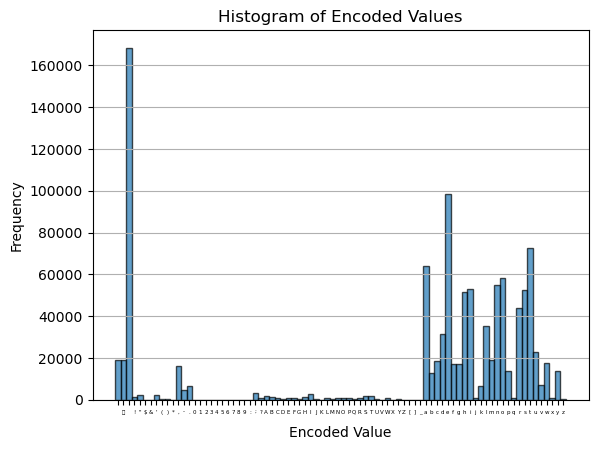

<Figure size 1500x500 with 0 Axes>

In [47]:
# Take a look at our encoded training data
encoded_vals = train_data

# Plot a histogram to show the distribution of our training data
plt.hist(encoded_vals, bins=range(len(chars)+1), alpha=0.7, edgecolor='black', align='left')
plt.title('Histogram of Encoded Values')
plt.xlabel('Encoded Value')
plt.ylabel('Frequency')
plt.xticks(range(len(chars)), chars, fontsize=4)
plt.grid(axis='y')
plt.figure(figsize=(15,5))
plt.tight_layout()
plt.show()